In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [8]:
##########################
# This notebook contains the final results after our feature engineering and finetuning..
###########################

In [9]:
data = pd.read_csv("./data/augmented_data.csv")

In [10]:
data.nunique()

period                     5
minute                   139
second                    60
possession               290
duration               77925
competition_id            17
season_id                 41
match_id                3312
timestamp              82726
team                     288
player                  5638
freeze_frame           82866
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length   

In [11]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "player", "freeze_frame", "timestamp", "team", "xg_so_far", "location_x", "location_y", "body_part", "defenders_3m_radius", "under_pressure", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.059020
shooting_range         0.051975
best_distance          0.049539
defenders_triangle     0.040640
location_x_distance    0.036295
goalkeeper_x           0.029198
goalkeeper_y           0.020718
location_y_distance    0.020590
is_penalty             0.015390
open_goal              0.013832
pass_length            0.011467
own_past_minute        0.011193
pass_duration          0.010458
period                 0.007341
player_type            0.006826
good_foot              0.005969
num_passes             0.005237
first_time             0.004870
was_leading            0.004621
past_minute            0.004551
pass_angle             0.004472
one_on_one             0.004096
minute                 0.003328
game_state             0.002962
own_past_15            0.002874
aerial_won             0.002542
past_15                0.002280
possession             0.001889
is_extra_time          0.001564
second                 0.001197
shots_so_far           0.000983
is_heade

In [12]:
# drop redundant features
data.drop(["location_x", "location_y_distance", "body_part", "defenders_3m_radius", "under_pressure", "player_type", "goal_distance"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "timestamp", "team", "player", "freeze_frame", "xg_so_far"], axis=1, inplace=True)
# drop low information features
data.drop(["period", "minute", "second", "possession", "aerial_won", "follows_dribble", "num_passes", "pass_length", "pass_duration", "pass_height", "pass_type", "pass_angle", "shots_so_far"], axis=1, inplace=True)
# drop penalties
data = data[data["is_penalty"] == False]

In [13]:
data.nunique()

play_pattern               9
position                  25
location_x_distance      635
location_y               701
technique                  7
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45441
shooting_range         43788
best_distance          30176
statsbomb_xg           82416
is_goal                    2
good_foot                  2
game_state                24
was_leading                3
past_minute                6
past_15                   28
own_past_minute            6
own_past_15               24
is_extra_time              2
dtype: int64

In [14]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "type", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [15]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [16]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal"], axis=1)

In [17]:
# Prepare data for regression
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=data.drop(["statsbomb_xg", "is_goal"], axis=1).columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [18]:
# Prepare data for classification
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=data.drop(["statsbomb_xg", "is_goal"], axis=1).columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [19]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [20]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [21]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [22]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [23]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=100, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [24]:
def random_forest():
    rf = RandomForestClassifier(max_depth=8, min_samples_split=100, n_estimators=100, max_features=None)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    calculate_stats(y_test, y_pred, "Random Forest")

    return rf.predict_proba(X_test)

In [25]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.09, max_depth=8, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [26]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.03888841537497916
Root Mean Squared Error: 0.061993158529885364
R-squared (R2 Score): 0.7490237987890822


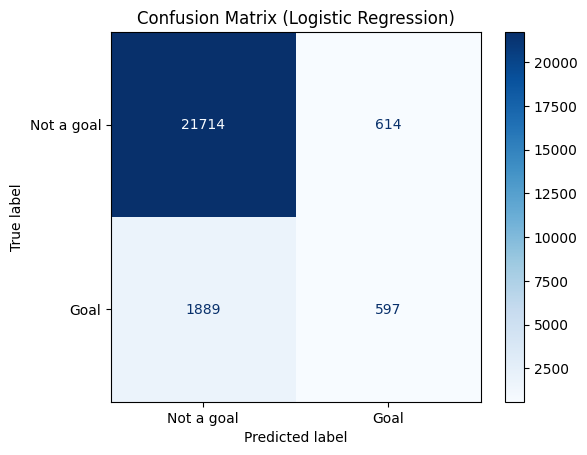


Logistic Regression
Accuracy: 0.8991295236560006
Precision: 0.4929810074318745
Recall: 0.24014481094127113
F1: 0.32296456586421424


In [27]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

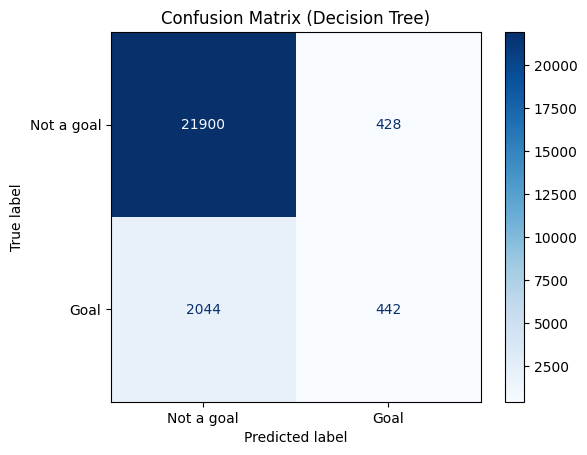


Decision Tree
Accuracy: 0.9003788184089627
Precision: 0.5080459770114942
Recall: 0.17779565567176187
F1: 0.2634088200238379


In [28]:
dt_xg, viz = decision_tree()

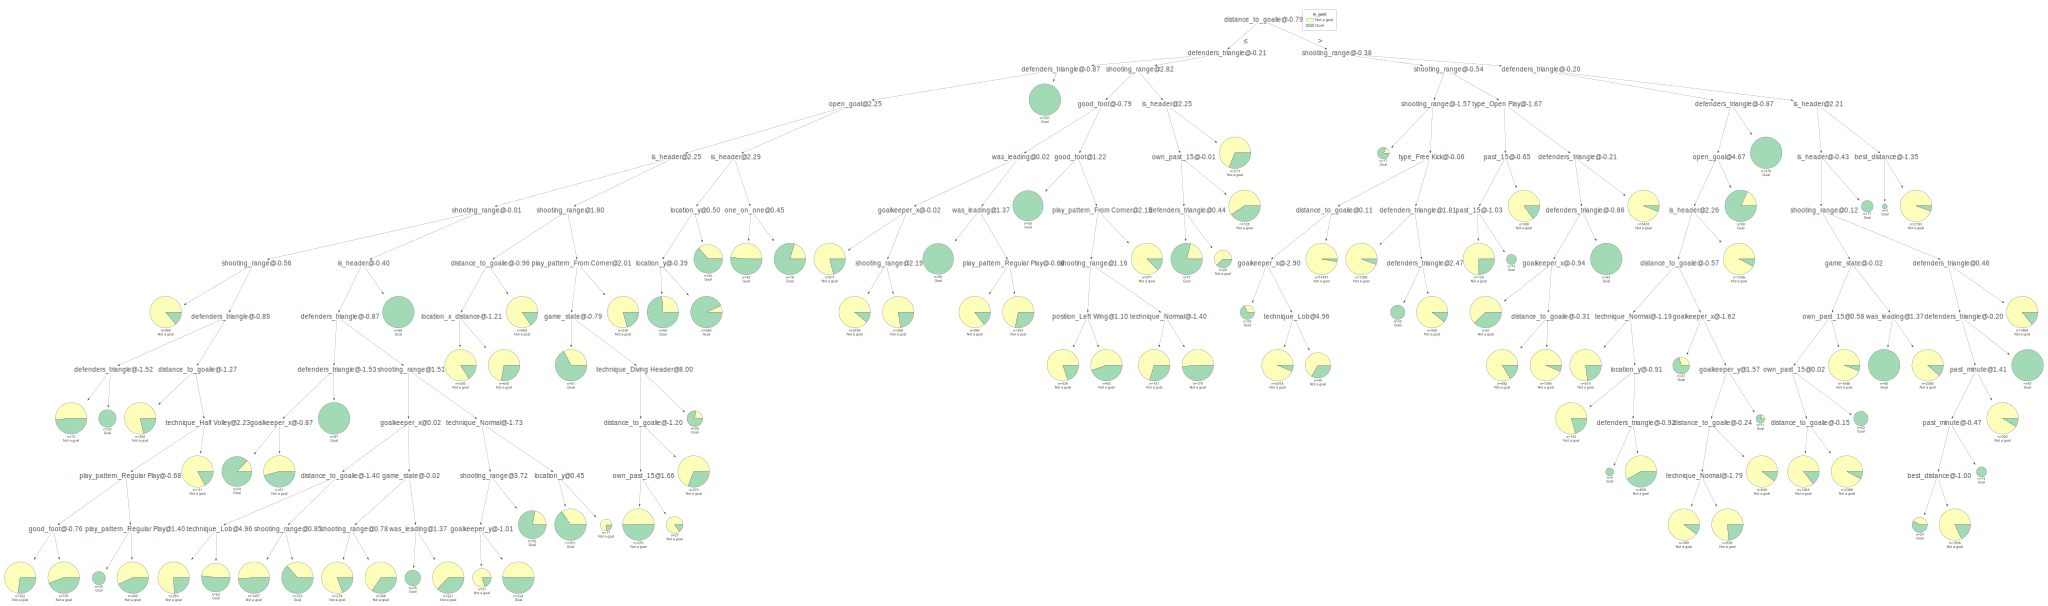

In [29]:
viz.view(fancy=False)

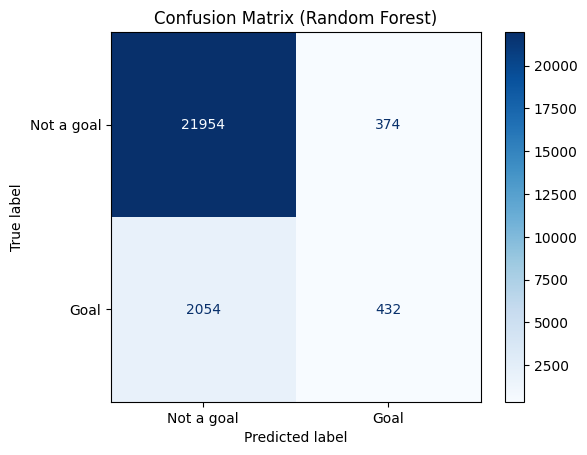


Random Forest
Accuracy: 0.902152010961554
Precision: 0.5359801488833746
Recall: 0.1737731295253419
F1: 0.2624544349939247


In [30]:
rf_xg = random_forest()

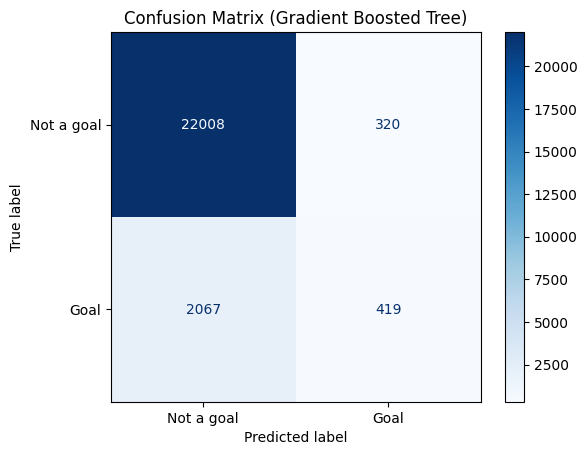


Gradient Boosted Tree
Accuracy: 0.9038043040219231
Precision: 0.5669824086603519
Recall: 0.168543845534996
F1: 0.2598449612403101


In [31]:
gbt_xg = gradient_boosted_tree()

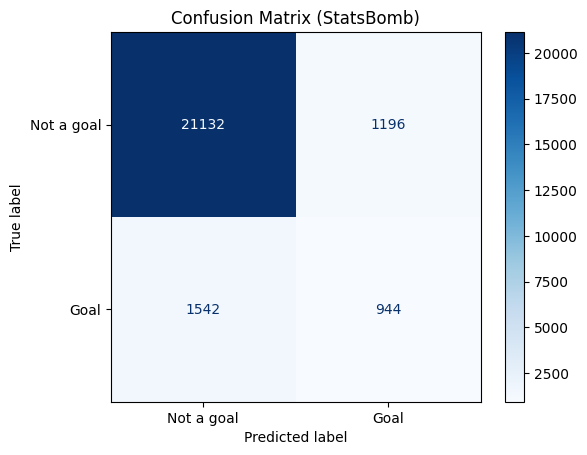


StatsBomb
Accuracy: 0.8896590634319336
Precision: 0.4411214953271028
Recall: 0.3797264682220434
F1: 0.40812797233030695


In [32]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.25))
calculate_stats(y_test, sb_pred, "StatsBomb")

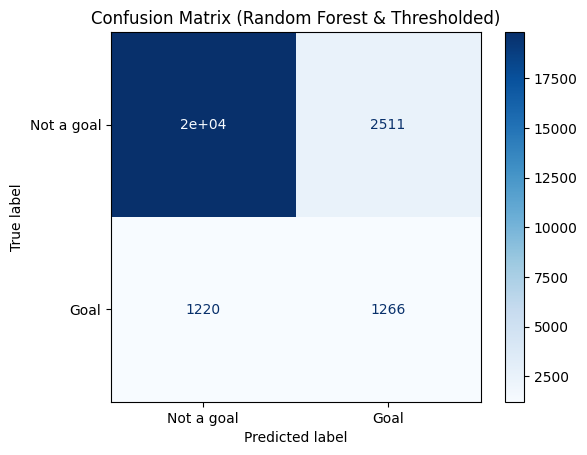


Random Forest & Thresholded
Accuracy: 0.8496413315064076
Precision: 0.335186656076251
Recall: 0.5092518101367659
F1: 0.404279099473096


In [33]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
rf_pred = [math.ceil(x[1]-0.25) for x in rf_xg]
calculate_stats(y_test, rf_pred, "Random Forest & Thresholded")

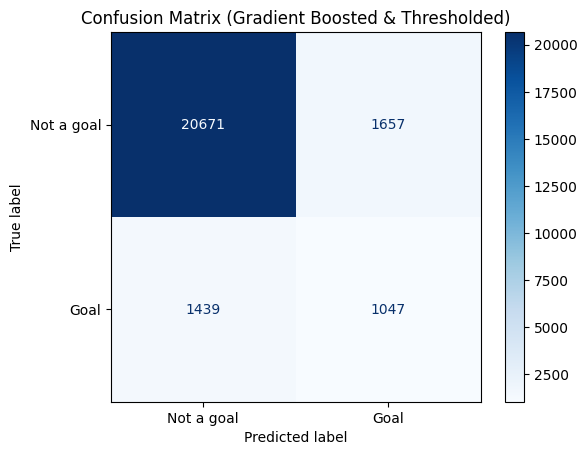


Gradient Boosted & Thresholded
Accuracy: 0.8752317240267591
Precision: 0.38720414201183434
Recall: 0.42115848753016893
F1: 0.40346820809248557


In [34]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.25) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [35]:
# This reveals the correlation between our predictions and StatsBomb xG (higher is better, for the most part)
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "rf_xg": [x[1] for x in rf_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
lrcoef = (pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
lorcoef = (pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
dtcoef = (pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
rfcoef = (pd.DataFrame(np.corrcoef(np.asarray(df["rf_xg"]), np.asarray(df["sxg"]))))
gbtcoef = (pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

In [36]:
print(f"Linear Regression: {lrcoef.iloc[0, 1]}")
print(f"Logistic Regression: {lorcoef.iloc[0, 1]}")
print(f"Decision Tree: {dtcoef.iloc[0, 1]}")
print(f"Random Forest: {rfcoef.iloc[0, 1]}")
print(f"xGBoost: {gbtcoef.iloc[0, 1]}")

Linear Regression: 0.865514104280918
Logistic Regression: 0.8837411469273687
Decision Tree: 0.8426671172375888
Random Forest: 0.8842355646250473
xGBoost: 0.8615104196601737


In [37]:
# This gives us a copy of the data to compare against
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy[data_copy["is_penalty"] == False], y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg

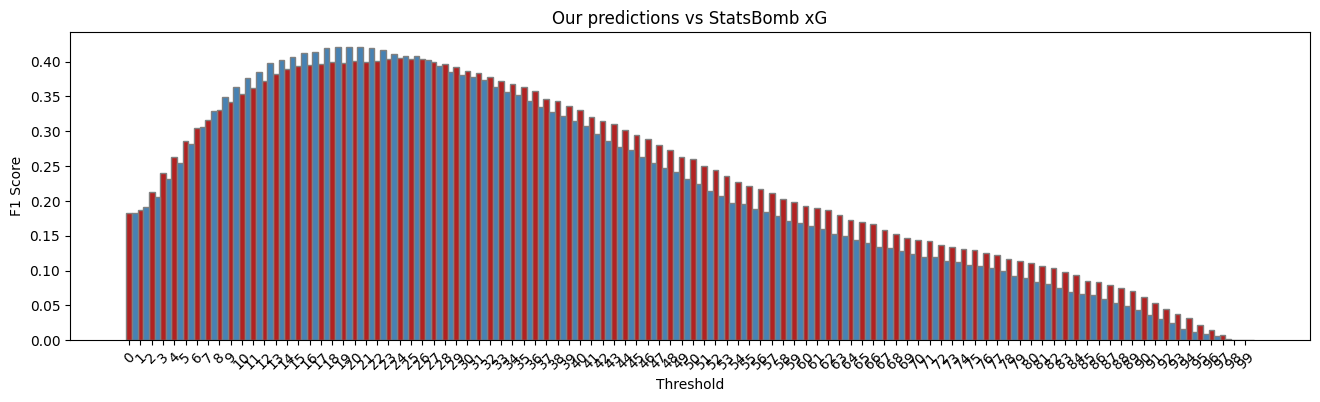

In [38]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.title("Our predictions vs StatsBomb xG")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()

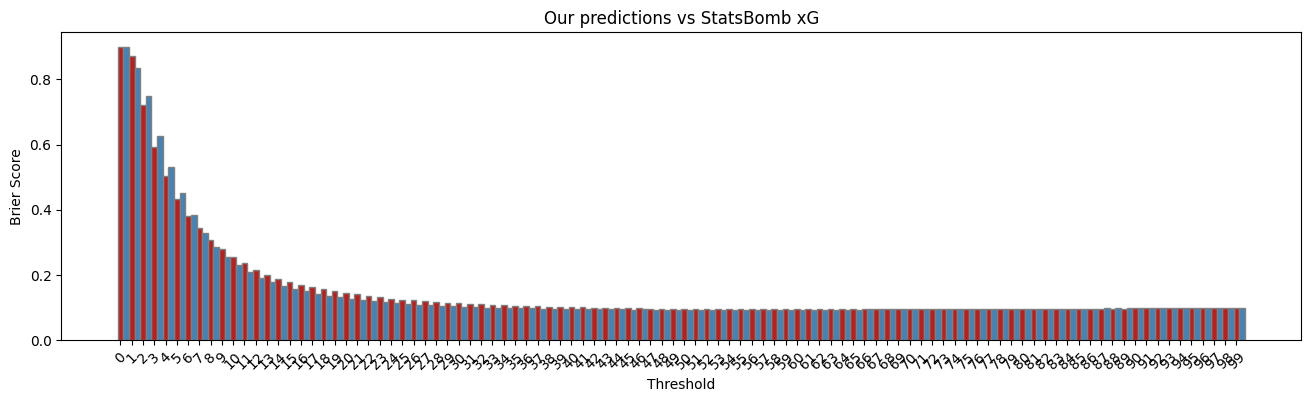

0.10018537922140727


In [39]:
my_brier_scores = []
sb_brier_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_brier = brier_score_loss(y_test, gbt_pred)
    sb_brier = brier_score_loss(y_test, sb_pred)
    my_brier_scores.append(my_brier)
    sb_brier_scores.append(sb_brier)

barWidth = 0.5
r1 = np.arange(len(my_brier_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_brier_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_brier_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.title("Our predictions vs StatsBomb xG")
plt.xlabel("Threshold")
plt.ylabel("Brier Score")

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()
print(my_brier_scores[-1])

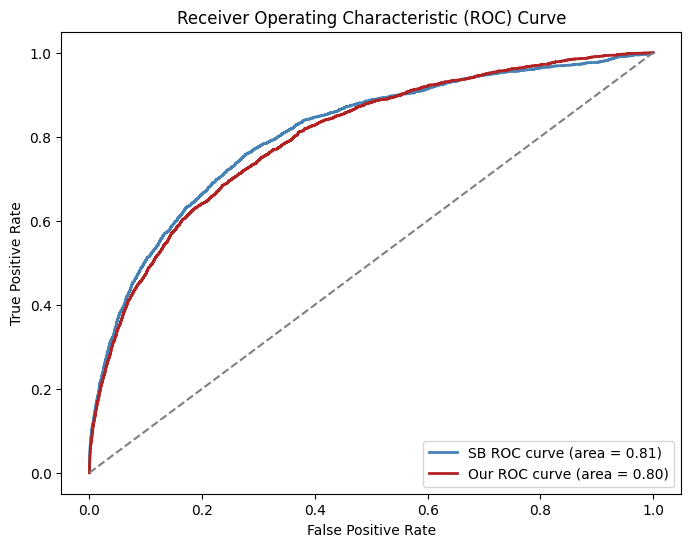

In [40]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, [x[1] for x in gbt_xg])
roc_auc1 = roc_auc_score(y_test, [x[1] for x in gbt_xg])
fpr2, tpr2, thresholds2 = roc_curve(y_test, sb_xg)
roc_auc2 = roc_auc_score(y_test, sb_xg)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='steelblue', lw=2, label='SB ROC curve (area = {:.2f})'.format(roc_auc2))
plt.plot(fpr1, tpr1, color='firebrick', lw=2, label='Our ROC curve (area = {:.2f})'.format(roc_auc1))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

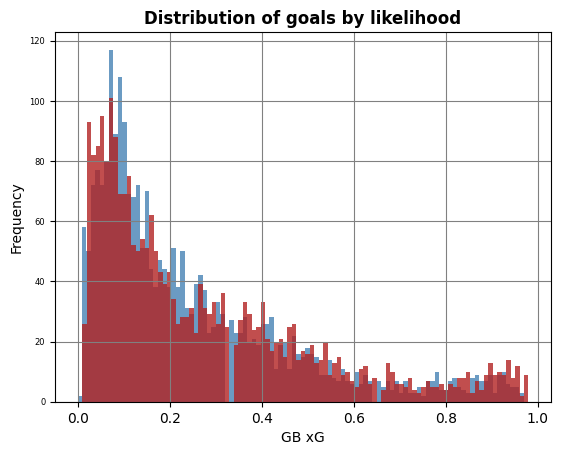

In [41]:
ax = data_copy_test[(data_copy_test["is_goal"] == True)]["sb_xg"].apply(lambda x: round(x, 2)).hist(bins=100, xlabelsize=10, ylabelsize=6, alpha=0.8, color="steelblue")
ax2 = data_copy_test[(data_copy_test["is_goal"] == True)]["gbt_xg"].apply(lambda x: round(x, 2)).hist(bins=100, xlabelsize=10, ylabelsize=6, alpha=0.8, color="firebrick")
ax.set_title('Distribution of goals by likelihood', weight='bold')
ax.set_xlabel('GB xG')
ax.set_ylabel('Frequency')
plt.show()

In [42]:
# We can now plot some PDPs to measure how changes in some of our key features affect our likelihood
dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=100, min_samples_split=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
importance = dt.feature_importances_

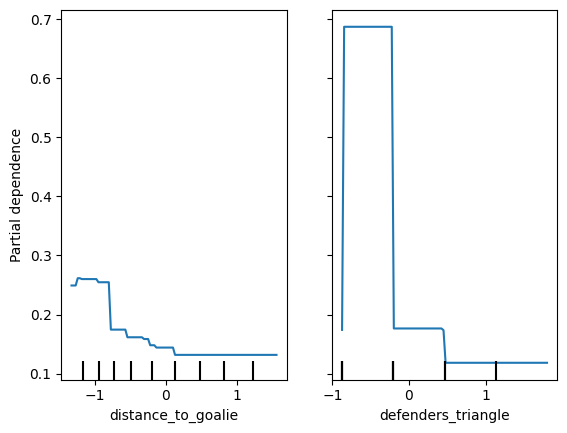

In [43]:
PartialDependenceDisplay.from_estimator(dt, X_train, ["distance_to_goalie", "defenders_triangle"])

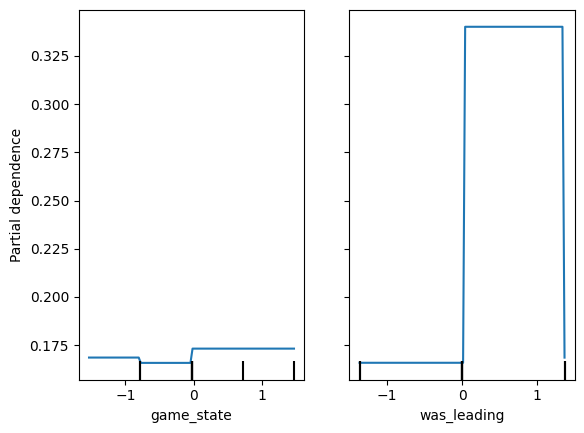

In [44]:
PartialDependenceDisplay.from_estimator(dt, X_train, ["game_state", "was_leading"])

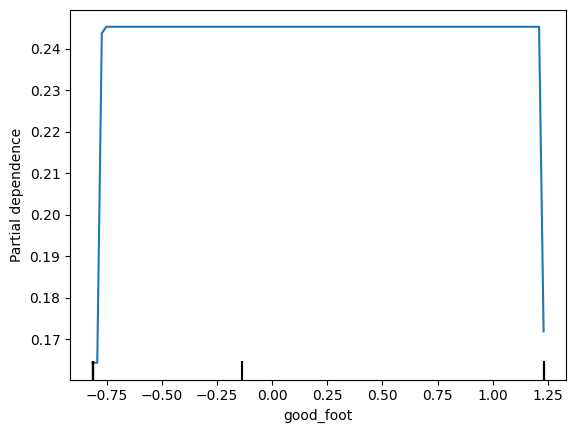

In [45]:
PartialDependenceDisplay.from_estimator(dt, X_train, ["good_foot"])

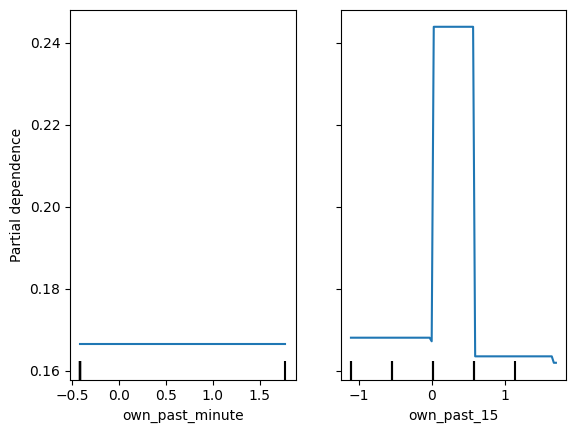

In [46]:
PartialDependenceDisplay.from_estimator(dt, X_train, ["own_past_minute", "own_past_15"])

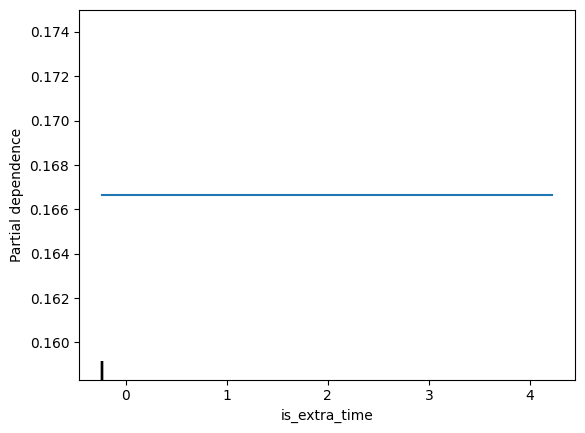

In [47]:
PartialDependenceDisplay.from_estimator(dt, X_train, ["is_extra_time"])